# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report
import pickle

import os
os.makedirs('saved_models', exist_ok=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy
TRANSFORMER_MODEL_NAME = 'bert-base-uncased'
SAVE_MODEL_SUFFIX = '1'
save_model_name = TRANSFORMER_MODEL_NAME.split('/')[-1]
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

nr_features = 768
batch_size = 16
learning_rate = 2e-5
epochs = 10
patience = 2
class_weight_beta = 0.999
use_class_weights = True

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [3]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [4]:

def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset, limit_nothing = False, limit_nothing_count = 200):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    tokens_list = []
    to_be_requested_list = []
    
    nothing_count = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                user_utterance = utterance
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            # if speaker == 0:
            #     if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
                    
            #     if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
            #         skip_bot = True
            #         continue
            #     skip_bot = False
            # else:
            #     if skip_bot:
            #         continue
            if speaker == 0:
                skip_bot = False
                if not any(da.startswith("Hotel") or da.startswith("Restaurant") or da.startswith("Booking") for da in act_types):
                    skip_bot = True
                    continue
            elif skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            to_be_requested = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # to_be_retrieved.add(domain + '-availability')
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                elif domain in ["hotel", "restaurant", "booking", "general"]: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name + ':' + slot_value for slot_name, slot_value in act_type_relevant_slots]))
                    
                    if len(to_be_retrieved) != 0 and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in to_be_retrieved)) and not "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability:yes')
                    elif "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability:no')
                    
                    to_be_requested_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value == '?' and slot_name != 'none']
                    to_be_requested.update(set([domain + '-' + slot_name for slot_name, _ in to_be_requested_relevant_slots]))
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                # if limit_nothing and len(to_be_requested) == 0:
                #     if nothing_count == limit_nothing_count:
                #         continue
                #     nothing_count += 1
                
                if len(to_be_requested) == 0:
                    to_be_requested.add('NOTHING')
                
                to_be_retrieved_list.append(list(to_be_retrieved))
                to_be_requested_list.append(list(to_be_requested))
                
                # print(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                input_text = user_utterance + ' | USER SLOTS PER ACT' + ', '.join(user_slots_per_act_type) + ' | RETRIEVED SLOTS' + ', '.join(to_be_retrieved)
                # print("INPUT TEXT:", input_text)
                
                # print("TO BE REQ:", to_be_requested)
                
                tokenized = transformer_tokenizer(input_text, padding = 'max_length')
                tokens_list.append(tokenized)
                
            
    return tokens_list, to_be_requested_list

In [5]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_to_be_requested_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_to_be_requested_list = extract_to_be_retrieved_info(test)
    val_embeddings_list, val_to_be_requested_list = extract_to_be_retrieved_info(val)

Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset multi_woz_v22 downloaded and prepared to /root/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/7452f16a8b502e97df5c04cc4ee5436464762fa93b1ce778dd14181e79d8b51a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 762/762 [00:01<00:00, 530.41it/s]


In [6]:
mlb = MultiLabelBinarizer().fit(train_to_be_requested_list)
pickle.dump(mlb, open('saved_models/MOVE_AGENT_REQ_mlb.pkl', 'wb'))
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_to_be_requested_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_to_be_requested_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_to_be_requested_list)
    

['NOTHING' 'booking-bookday' 'booking-bookpeople' 'booking-bookstay'
 'booking-booktime' 'hotel-area' 'hotel-bookday' 'hotel-bookpeople'
 'hotel-bookstay' 'hotel-booktime' 'hotel-internet' 'hotel-name'
 'hotel-parking' 'hotel-pricerange' 'hotel-stars' 'hotel-type'
 'restaurant-area' 'restaurant-bookday' 'restaurant-bookpeople'
 'restaurant-bookstay' 'restaurant-booktime' 'restaurant-food'
 'restaurant-name' 'restaurant-pricerange']


In [7]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_to_be_requested_list:
    for act_type in act_types:
        for i, class_ in enumerate(mlb.classes_):
            if class_ in act_type:
                samples_per_class[i] += 1
        # samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('NOTHING', 18869), ('booking-bookday', 52), ('booking-bookpeople', 46), ('booking-bookstay', 45), ('booking-booktime', 46), ('hotel-area', 1517), ('hotel-bookday', 697), ('hotel-bookpeople', 385), ('hotel-bookstay', 573), ('hotel-booktime', 24), ('hotel-internet', 156), ('hotel-name', 61), ('hotel-parking', 204), ('hotel-pricerange', 981), ('hotel-stars', 301), ('hotel-type', 193), ('restaurant-area', 818), ('restaurant-bookday', 402), ('restaurant-bookpeople', 231), ('restaurant-bookstay', 4), ('restaurant-booktime', 558), ('restaurant-food', 1339), ('restaurant-name', 44), ('restaurant-pricerange', 669)]
Class weights:
[('NOTHING', 0.05127073495954685), ('booking-bookday', 1.0113402376566452), ('booking-bookpeople', 1.1398558007255706), ('booking-bookstay', 1.164607611007302), ('booking-booktime', 1.1398558007255706), ('hotel-area', 0.06566457902055844), ('hotel-bookday', 0.10211333483380988), ('hotel-bookpeople', 0.16038121378726855), ('hotel-bookstay', 0.11750443257

In [8]:
def batchify_tokens_tags(tokens_list, encoded_agent_tags_list, batch_size):
    ids_batch = []
    mask_batch = []
    useful_pos_batch = []
    labels_batch = []
    
    if encoded_agent_tags_list is None:
        encoded_agent_tags_list = range(len(tokens_list))
    
    for tokens, agent_encoded_tags in zip(tokens_list, encoded_agent_tags_list):
        ids_batch.append(tokens.input_ids)
        mask_batch.append(tokens.attention_mask)
        labels_batch.append(agent_encoded_tags)
        
        if len(ids_batch) == batch_size:
            yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), torch.Tensor(labels_batch).cuda()
            ids_batch.clear()
            mask_batch.clear()
            labels_batch.clear()
    
    yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(transformer, tokens_list, encoded_agent_tags_list, batch_size, criterion):
    transformer.eval()
    losses = []
    with torch.no_grad():
        for ids_batch, mask_batch, labels_batch in batchify_tokens_tags(tokens_list, encoded_agent_tags_list, batch_size):
            out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
            
            # logits_useful, labels_useful = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
            logits_useful = out.logits
            labels_useful = labels_batch
            
            loss = criterion(logits_useful, labels_useful)
            losses.append(loss.item())
    transformer.train()
    return np.mean(losses)

def predict(transformer, tokens, batch_size):
    transformer.eval()
    predictions = []
    with torch.no_grad():
        for ids_batch, mask_batch, _ in batchify_tokens_tags(tokens, None, batch_size):
            out = transformer.forward(input_ids = ids_batch, attention_mask = mask_batch)
            res = (out.logits > 0).cpu().detach().numpy()
            predictions.append(res)
    return np.concatenate(predictions)

In [9]:
transformer = AutoModelForSequenceClassification.from_pretrained(TRANSFORMER_MODEL_NAME, num_labels = len(mlb.classes_), ignore_mismatched_sizes = True, problem_type = "multi_label_classification").cuda()
transformer.train()

if use_class_weights:
    criterion = nn.BCEWithLogitsLoss(weight = class_weights)
else:
    criterion = nn.BCEWithLogitsLoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_27/2486679920.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  yield torch.Tensor(ids_batch).long().cuda(), torch.Tensor(mask_batch).cuda(), torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.028713336694265575, Val loss = 0.01325678906684357
Epoch 2: Train loss = 0.012225049481214348, Val loss = 0.0107773996208346
Epoch 3: Train loss = 0.010291787416703427, Val loss = 0.009151216954850251
Epoch 4: Train loss = 0.009103499962050367, Val loss = 0.008906032384383103
Epoch 5: Train loss = 0.008381346211264533, Val loss = 0.008994038985480391
Epoch 6: Train loss = 0.0076650651872809655, Val loss = 0.009031834643181394
Epoch 7: Train loss = 0.0070506684867954, Val loss = 0.00901629755251287
Epoch 8: Train loss = 0.006503522314433224, Val loss = 0.008723493610020904
Epoch 9: Train loss = 0.006040519163786099, Val loss = 0.008871122533621798
Epoch 10: Train loss = 0.005465984064464322, Val loss = 0.009212220280749044


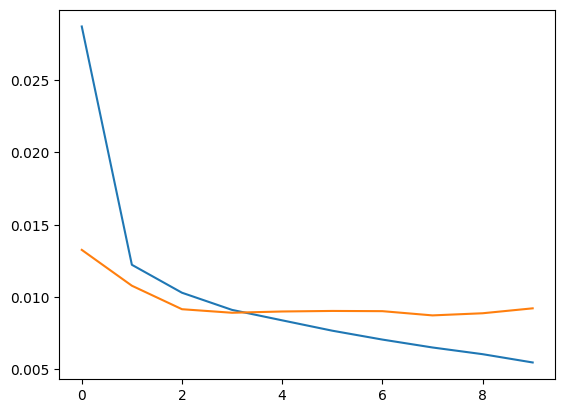

In [10]:
optim = torch.optim.Adam(transformer.parameters(), lr = learning_rate)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for ids_batch, mask_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = transformer.forward(input_ids = ids_batch, attention_mask= mask_batch)
        
        loss = criterion(out.logits, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(transformer, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        transformer.save_pretrained('saved_models/MOVE_AGENT_REQ_' + save_model_name + '_' + SAVE_MODEL_SUFFIX)
        
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [11]:
transformer = AutoModelForSequenceClassification.from_pretrained('saved_models/MOVE_AGENT_REQ_' +  save_model_name + '_' + SAVE_MODEL_SUFFIX, num_labels = len(mlb.classes_)).cuda()

predicted_output = predict(transformer, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                       precision    recall  f1-score   support

              NOTHING      0.931     0.910     0.920      2168
      booking-bookday      0.000     0.000     0.000         5
   booking-bookpeople      0.000     0.000     0.000         3
     booking-bookstay      0.000     0.000     0.000         0
     booking-booktime      0.000     0.000     0.000         5
           hotel-area      0.627     0.690     0.657       168
        hotel-bookday      0.600     0.464     0.523        97
     hotel-bookpeople      0.533     0.291     0.376        55
       hotel-bookstay      0.636     0.298     0.406        94
       hotel-booktime      0.000     0.000     0.000         0
       hotel-internet      1.000     0.059     0.111        17
           hotel-name      1.000     0.600     0.750         5
        hotel-parking      1.000     0.048     0.091        21
     hotel-pricerange      0.091     0.009     0.016       111
          hotel-stars      0.000     0.000     0.000  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
